In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
from PhysicsDatasets import SHODatasetXV, DampedSHODatasetXV, DampedSHODatasetV2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import json
from matplotlib.colors import LogNorm
from utils import load_model
import utils
import os
from datetime import datetime
import yaml

In [2]:
base_dir = "trainings"
trainings = os.listdir("trainings")
print("\n".join(trainings))

discrete_mkb_mLo_kHi_betaMid
continuous_mkb_mLo_kHi_beta0123_noRoPE
continuous_mkb_mLo_kHi_beta012
continuous_mkb_mLo_kHi_betaMid
continuous_mkb_mLo_kHi_beta0
continuous_mkb_mLo_kHi_betaHi
continuous_mkb_mLo_kHi_betaLoHi2_noRoPE
random_SHO_05Dec24_1025
discrete_mkb_mLo_kHi_beta01_noRoPE
continuous_mkb_mLo_kHi_betaAll
continuous_mkb_mLo_kHi_beta0_noRoPE
discrete_mkb_mLo_kHi_beta0_noRoPE
continuous_mkb_mLo_kHi_beta01
discrete_mkb_mLo_kHi_betaLo_noRoPE
discrete_mkb_mLo_kHi_beta0123_noRoPE
continuous_mkb_mLo_kHi_betaHi_noRoPE
discrete_mkb_mLo_kHi_betaHi
random_SHO_05Dec24_1409
continuous_mkb_mLo_kHi_betaLo_noRoPE
discrete_mkb_mLo_kHi_betaLoHi1
continuous_mkb_mLo_kHi_betaLo
discrete_mkb_mLo_kHi_betaMid_noRoPE
discrete_mkb_mLo_kHi_beta0
random_SHO_05Dec24_1414
discrete_mkb_mLo_kHi_betaLo
discrete_mkb_mLo_kHi_betaLoHi2_noRoPE
continuous_mkb_mLo_kHi_betaMid_noRoPE
discrete_mkb_mLo_kHi_betaAll
continuous_mkb_mLo_kHi_betaAll_noRoPE
discrete_mkb_mLo_kHi_beta012_noRoPE
continuous_mkb_mLo_kHi_beta0

# Small masses, high k, undamped - with RoPE
See if model can generalize to high mass / low k

In [3]:
model_name = "continuous_mkb_mLo_kHi_beta0"
runs = [s for s in os.listdir(f"{base_dir}/{model_name}/")]
runs_time = [datetime.strptime(s,"%d%b%y_%H%M") for s in runs]
imax = max(enumerate(runs_time), key=lambda x: x[1])[0]
run = runs[imax]
model_dir = f"{base_dir}/{model_name}/{run}/"

config = utils.load_config(f"{model_dir}/config.yaml")
model = utils.load_model_v2(config,model_dir,ckpt='best')

cfg_dset = config['dataset_params']
seq_len = cfg_dset['seq_len']
dt = cfg_dset['dt']

masses = np.arange(1,11)
ks = np.arange(10,21)
beta = 0
num_ctx = seq_len-1
num_trajectories_per = 100

output = np.zeros((num_ctx,len(masses),len(ks)))
for i,m in enumerate(masses):
    for j,k in enumerate(ks):
        dset = DampedSHODatasetXV(num_trajectories=num_trajectories_per,
                                  masses=m,
                                  k=k,
                                  beta=beta,
                                  seq_len=seq_len,
                                  dt=dt)
        inpt, target = dset.xv[:,:-1,:], dset.xv[:,1:,:]
        with torch.no_grad():
            pred = model(inpt)
        mse = torch.mean(torch.sum((pred-target)**2,dim=-1),dim=0)
        output[:,i,j] = mse

Using RoPE
number of parameters: 1.58M


/n/home11/sambt/hidenori/physics_icl/utils.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{tgt_dir}/{models[0]}",map_location='cpu')

In [5]:
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation, PillowWriter

dm = masses[1]-masses[0]
dk = ks[1]-ks[0]

fig,ax = plt.subplots(figsize=(8, 6))
X, Y = np.meshgrid(masses, ks)
Z = output[0]
heatmap = plt.imshow(Z.T, extent=[masses[0]-0.5*dm, masses[-1]+0.5*dm, ks[0]-0.5*dk, ks[-1]+0.5*dk],
                     origin='lower', cmap='viridis', aspect='auto',norm=LogNorm(vmin=Z.min(),vmax=Z.max()))
#w0 = np.sqrt(Y/X)
#contour = plt.contour(X, Y, w0, levels=[beta], colors='white', linewidths=2)
#plt.clabel(contour, inline=True, fontsize=16, fmt=f"$\\omega_0 = \\beta = {beta}$")  # Label the contour line

# Add a color bar
cbar = plt.colorbar(heatmap)
cbar.set_label('Mean MSE over 100 inits',fontsize=16)
# Add labels and title
plt.xlabel('Mass',fontsize=16)
plt.ylabel('Spring Constant',fontsize=16)
plt.title(f"$\\beta = {beta}$",fontsize=16)

#plt.text(2,14,"Underdamped",rotation=72,color='white',fontsize=16)
#plt.text(4.5,14,"Overdamped",rotation=72,color='white',fontsize=16)
tx_context = plt.text(7.2,19.5,"Context = 1",rotation=0,color='white',fontsize=16)

# Update function for animation
def update(frame):
    heatmap.set_data(output[frame].T)  # Update the image data
    #ax.set_title(f"Context = {frame+1}, $\\beta = {beta}$")  # Update the title with frame number
    tx_context.set_text(f"Context = {frame+1}")
    return [heatmap]

# Create the animation
ani = FuncAnimation(fig, update, frames=output.shape[0], interval=250, blit=True)
# Save the animation as a GIF
output_filename = f"animation_beta{beta}.gif"
ani.save(output_filename, writer=PillowWriter(fps=3))
# Close the figure after saving
plt.close(fig)

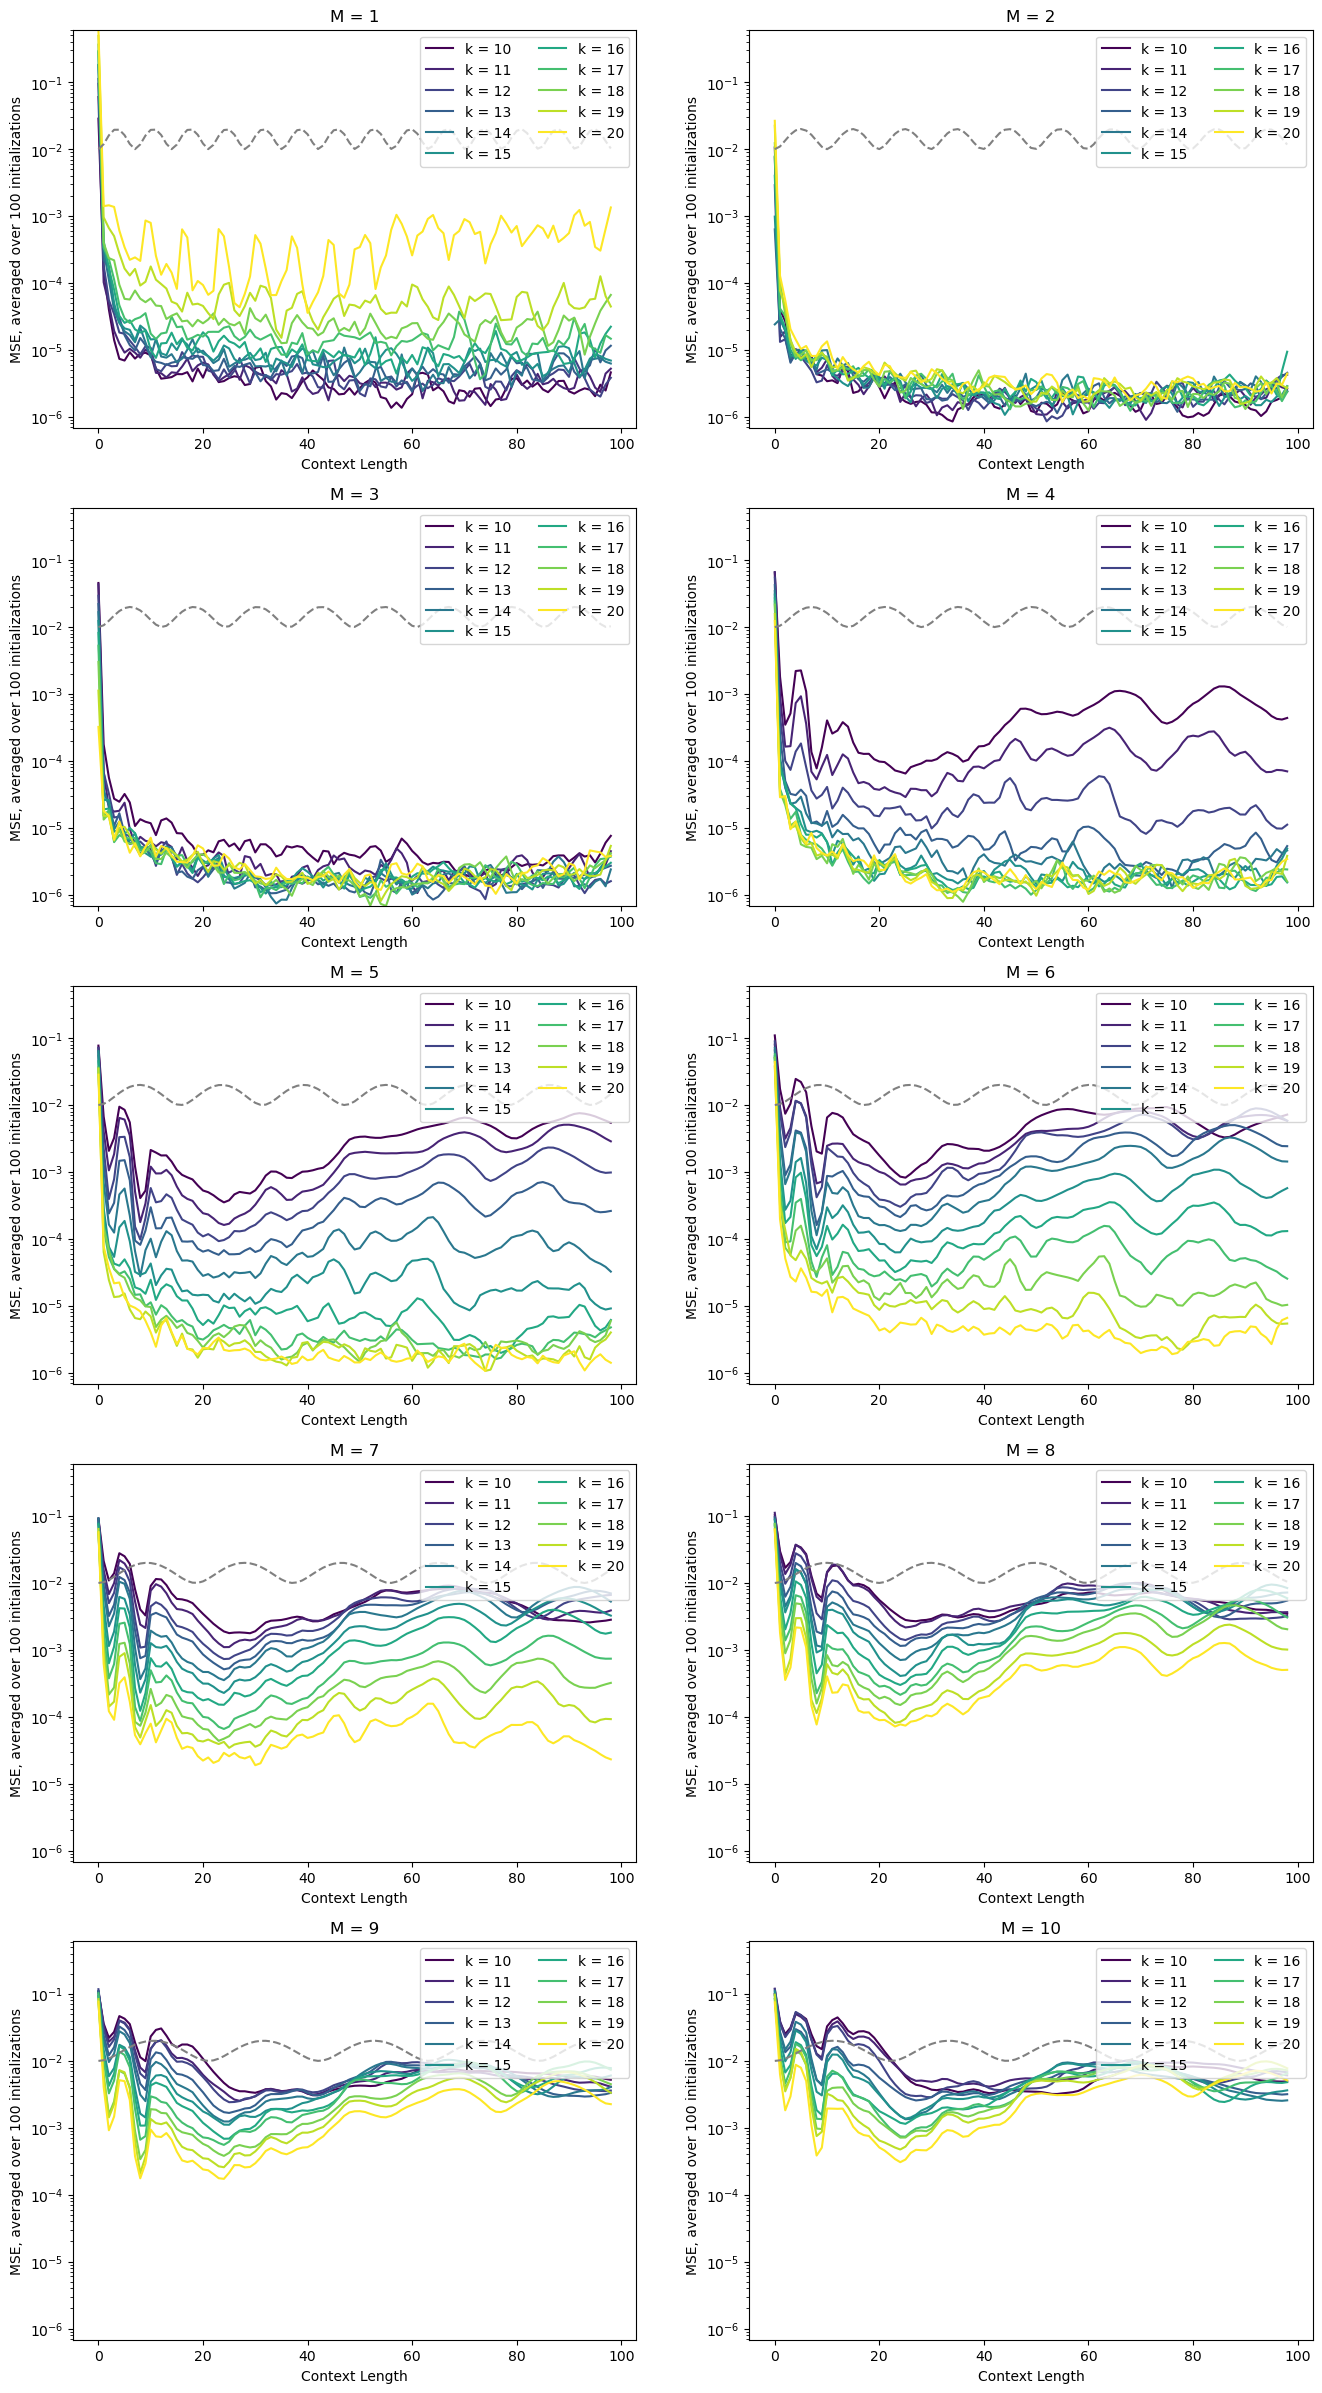

In [4]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i / (len(ks) - 1)) for i in range(len(ks))]

fig,axes = plt.subplots(len(masses)//2 + len(masses)%2,2,figsize=(8*2,6*(len(masses)//2)))
for i in range(len(masses)):
    plt.sca(axes.flatten()[i])
    title = f"M = {masses[i]}"
    for j in range(len(ks)):
        series = output[:,i,j]
        plt.plot(np.arange(len(series)),series,label=f"k = {ks[j]}",color=colors[j])
    w = np.sqrt(ks[j]/masses[i])
    time = dt*np.arange(len(series))
    plt.plot(np.arange(len(series)),1e-2+(0.1*np.sin(w*time))**2,color='gray',linestyle='--')
             
    plt.ylim([output.min(),output.max()])
    plt.yscale('log')
    plt.legend(loc='upper right',ncol=2)
    plt.title(title)
    plt.xlabel("Context Length")
    plt.ylabel("MSE, averaged over 100 initializations")

# Small masses, high k, undamped - without RoPE
See if model can generalize to high mass / low k

In [5]:
model_name = "continuous_mkb_mLo_kHi_beta0_noRoPE"
runs = [s for s in os.listdir(f"{base_dir}/{model_name}/")]
runs_time = [datetime.strptime(s,"%d%b%y_%H%M") for s in runs]
imax = max(enumerate(runs_time), key=lambda x: x[1])[0]
run = runs[imax]
model_dir = f"{base_dir}/{model_name}/{run}/"

config = utils.load_config(f"{model_dir}/config.yaml")
model = utils.load_model_v2(config,model_dir,ckpt='best')

cfg_dset = config['dataset_params']
seq_len = cfg_dset['seq_len']
dt = cfg_dset['dt']

masses = np.arange(1,11)
ks = np.arange(10,21)
beta = 0
num_ctx = seq_len-1
num_trajectories_per = 100

output = np.zeros((num_ctx,len(masses),len(ks)))
for i,m in enumerate(masses):
    for j,k in enumerate(ks):
        dset = DampedSHODatasetXV(num_trajectories=num_trajectories_per,
                                  masses=m,
                                  k=k,
                                  beta=beta,
                                  seq_len=seq_len,
                                  dt=dt)
        inpt, target = dset.xv[:,:-1,:], dset.xv[:,1:,:]
        with torch.no_grad():
            pred = model(inpt)
        mse = torch.mean(torch.sum((pred-target)**2,dim=-1),dim=0)
        output[:,i,j] = mse

number of parameters: 1.58M


In [8]:
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation, PillowWriter

dm = masses[1]-masses[0]
dk = ks[1]-ks[0]

fig,ax = plt.subplots(figsize=(8, 6))
X, Y = np.meshgrid(masses, ks)
Z = output[0]
heatmap = plt.imshow(Z.T, extent=[masses[0]-0.5*dm, masses[-1]+0.5*dm, ks[0]-0.5*dk, ks[-1]+0.5*dk],
                     origin='lower', cmap='viridis', aspect='auto',norm=LogNorm(vmin=Z.min(),vmax=Z.max()))
#w0 = np.sqrt(Y/X)
#contour = plt.contour(X, Y, w0, levels=[beta], colors='white', linewidths=2)
#plt.clabel(contour, inline=True, fontsize=16, fmt=f"$\\omega_0 = \\beta = {beta}$")  # Label the contour line

# Add a color bar
cbar = plt.colorbar(heatmap)
cbar.set_label('Mean MSE over 100 inits',fontsize=16)
# Add labels and title
plt.xlabel('Mass',fontsize=16)
plt.ylabel('Spring Constant',fontsize=16)
plt.title(f"$\\beta = {beta}$",fontsize=16)

#plt.text(2,14,"Underdamped",rotation=72,color='white',fontsize=16)
#plt.text(4.5,14,"Overdamped",rotation=72,color='white',fontsize=16)
tx_context = plt.text(7.2,19.5,"Context = 1",rotation=0,color='white',fontsize=16)

# Update function for animation
def update(frame):
    heatmap.set_data(output[frame].T)  # Update the image data
    #ax.set_title(f"Context = {frame+1}, $\\beta = {beta}$")  # Update the title with frame number
    tx_context.set_text(f"Context = {frame+1}")
    return [heatmap]

# Create the animation
ani = FuncAnimation(fig, update, frames=output.shape[0], interval=250, blit=True)
# Save the animation as a GIF
output_filename = f"animation_beta{beta}.gif"
ani.save(output_filename, writer=PillowWriter(fps=3))
# Close the figure after saving
plt.close(fig)

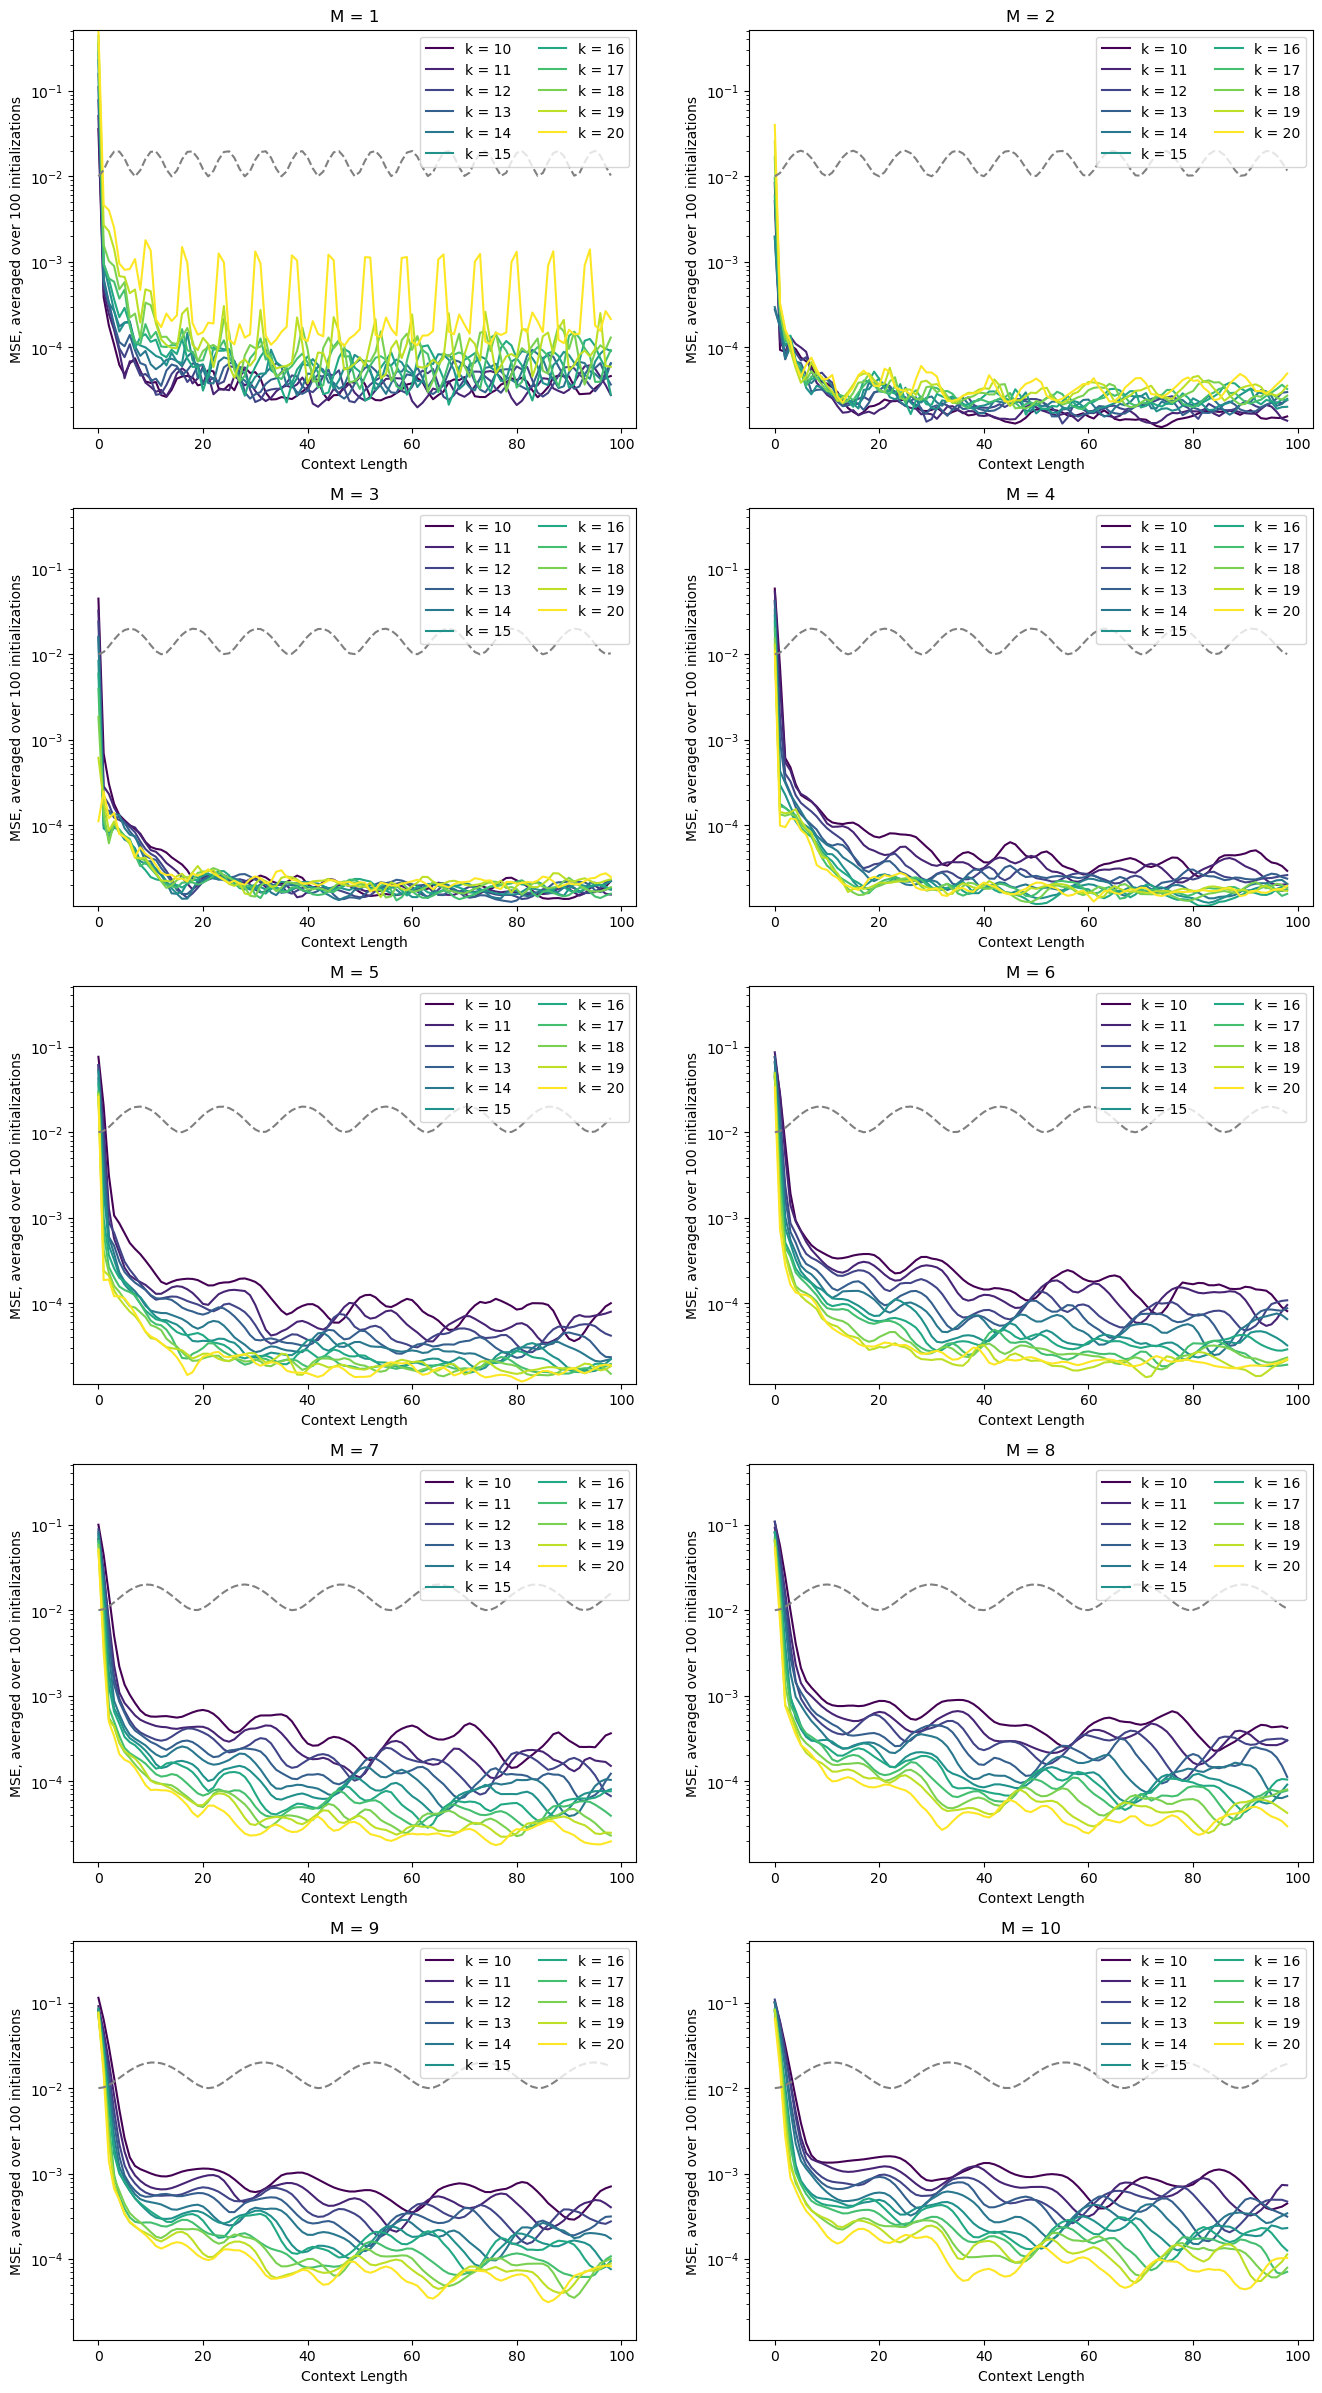

In [6]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i / (len(ks) - 1)) for i in range(len(ks))]

fig,axes = plt.subplots(len(masses)//2 + len(masses)%2,2,figsize=(8*2,6*(len(masses)//2)))
for i in range(len(masses)):
    plt.sca(axes.flatten()[i])
    title = f"M = {masses[i]}"
    for j in range(len(ks)):
        series = output[:,i,j]
        plt.plot(np.arange(len(series)),series,label=f"k = {ks[j]}",color=colors[j])
    w = np.sqrt(ks[j]/masses[i])
    time = dt*np.arange(len(series))
    plt.plot(np.arange(len(series)),1e-2+(0.1*np.sin(w*time))**2,color='gray',linestyle='--')
             
    plt.ylim([output.min(),output.max()])
    plt.yscale('log')
    plt.legend(loc='upper right',ncol=2)
    plt.title(title)
    plt.xlabel("Context Length")
    plt.ylabel("MSE, averaged over 100 initializations")